# Partial Correlations and Directed Acyclic Graphs

In [1]:
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin
import statsmodels.api as sm
from datlib.plots import *
import copy
import networkx as nx
plt.rcParams.update({"font.size": 32})

/Applications/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
length = 10000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0
sigma = 5

lst_dict = {col:[] for col in cols}

for i in range(length):
    lst_dict["P"].append(25 + np.random.normal(mu, 0.5 * sigma))
    lst_dict["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dict["X"].append(3 * lst_dict["Q"][-1] + np.random.normal(mu, sigma))
    lst_dict["Y"].append(lst_dict["Q"][-1] * -1 + np.random.normal(mu,sigma))
    lst_dict["Z"].append(lst_dict["P"][-1] * 2 + 1.5 * lst_dict["X"][-1] - lst_dict["Y"][-1] * 2 + np.random.normal(mu, sigma))

df = pd.DataFrame(lst_dict)
keys = cols 
df

P          Q           X          Y           Z
0     21.753238  51.968553  158.673339 -52.032001  386.050933
1     26.297406  45.921606  150.062394 -51.612707  373.418197
2     22.380462  41.343436  128.370581 -33.821981  311.437833
3     24.913338  49.672401  149.709470 -56.352961  393.029362
4     25.855596  48.254130  150.772198 -45.841197  365.114092
...         ...        ...         ...        ...         ...
9995  23.826826  44.330941  134.964293 -43.141004  333.242774
9996  27.983363  53.714485  170.526951 -56.857994  425.427532
9997  20.565171  54.550479  169.313691 -57.728676  416.052079
9998  24.549616  51.181811  152.514812 -55.854227  384.668031
9999  27.176255  52.608748  164.584164 -51.645029  409.211968

[10000 rows x 5 columns]

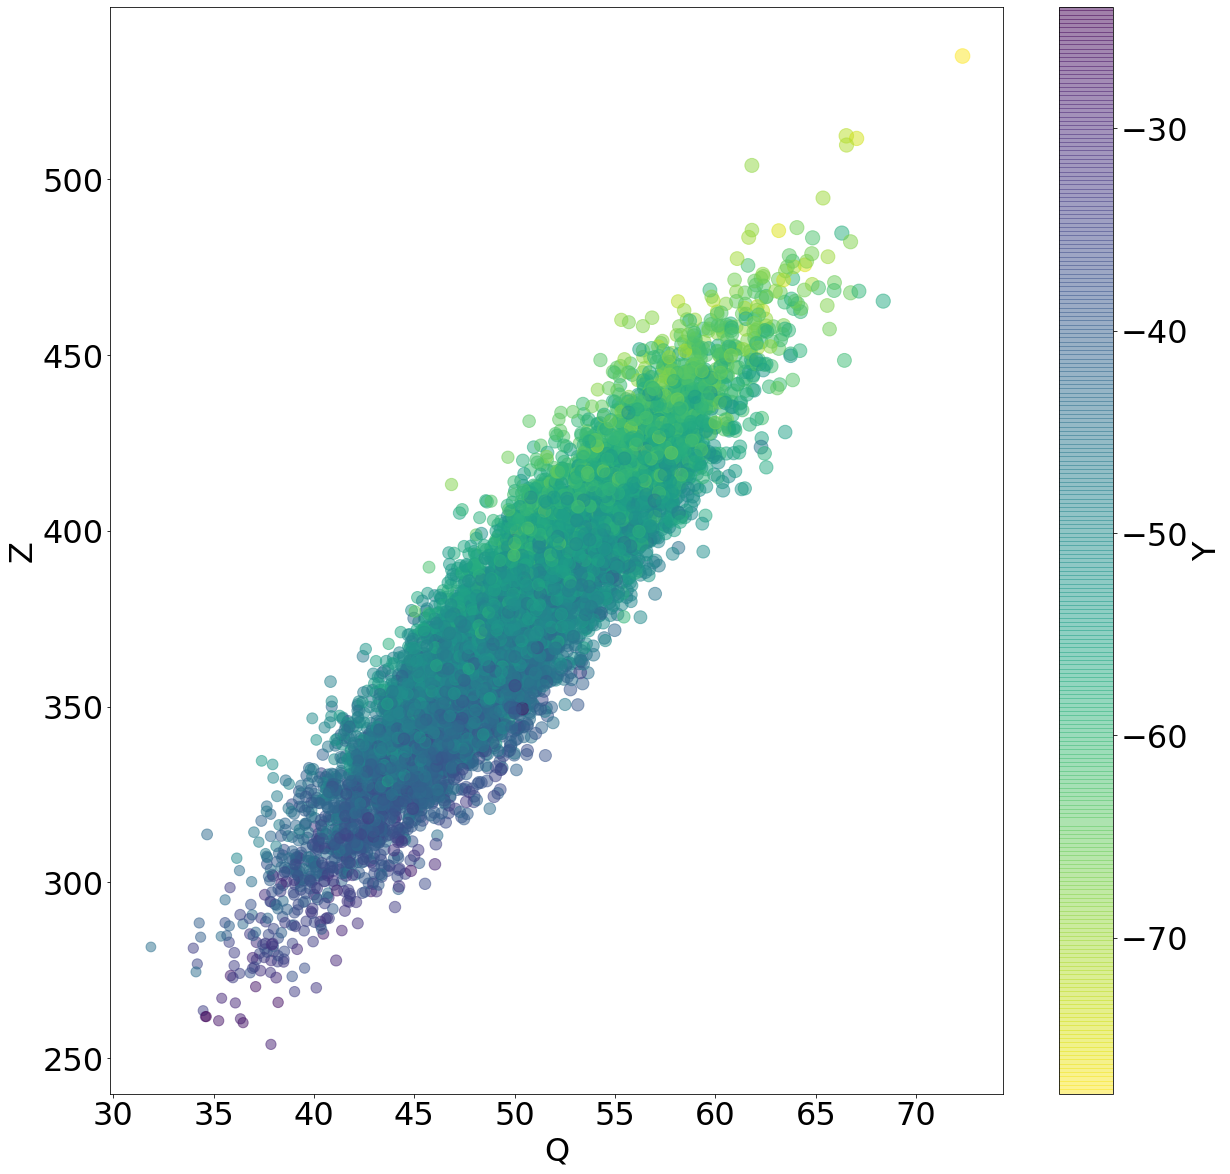

In [3]:
fig, ax = plt.subplots(figsize = (20,20))
df.plot.scatter(x = "Q", 
                y = "Z", 
                c = "Y", 
                s = "X", 
                cmap = "viridis_r", 
                alpha = 0.5, 
                ax = ax)
plt.show()
plt.close();

In [4]:
df.corr()

P         Q         X         Y         Z
P  1.000000 -0.003467 -0.009115 -0.002493  0.135403
Q -0.003467  1.000000  0.950434 -0.707944  0.916923
X -0.009115  0.950434  1.000000 -0.673377  0.934670
Y -0.002493 -0.707944 -0.673377  1.000000 -0.847781
Z  0.135403  0.916923  0.934670 -0.847781  1.000000

### Partial Correlation
Correlation of variables when controlling for other variables

In [5]:
residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    X["Constant"] = 1
    y = df[y_var]
    model = sm.OLS(y,X)
    results = model.fit()
    results.summary()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [6]:
residuals

P         Q         X         Y         Z
0    -1.752142 -0.550536  0.551818  0.227288  0.577435
1     2.483552 -4.191516  7.227748 -3.992413 -7.203121
2    -2.935046 -1.316244 -1.684471  4.150615  6.574948
3    -1.568295 -0.834221 -2.571339  1.097627  5.991386
4     1.524482 -1.559292  3.898838 -1.227895 -4.308882
...        ...       ...       ...       ...       ...
9995  0.185829 -0.908346  2.043112 -0.981525 -3.078317
9996  1.466484 -2.523442  2.894180 -0.530315  0.164027
9997 -3.614099 -1.405263 -0.927567  1.658071  5.688518
9998  0.981241  0.021504  1.920612 -2.878203 -4.894271
9999 -0.112483 -1.565133 -0.100316  2.157905  4.835596

[10000 rows x 5 columns]

In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 1.264e+05
Date:                Tue, 02 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:09:32   Log-Likelihood:                -30226.
No. Observations:               10000   AIC:                         6.046e+04
Df Residuals:                    9995   BIC:                         6.050e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
P              2.0088      0.020    100.852      0.000       1.970       2.048
Q              0.0685      0.033      2.061      0.039       0.003       0.134
X              1.4782      0.010    147.344      0.000       1.459       1.498
Y             -1.9960      0.010   -200.926      0.000      -2.015      -1.977
Constant      -0.2010      0.705     -0.285      0.776      -1.583       1.181
==============================================================================
Omnibus:                        3.240   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.083
Skew:                           0.003   Prob(JB):                        0.214
Kurtosis:                       2.914   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
residuals.corr()[residuals.corr().abs()<1].mul(-1).fillna(1).round(2)

P     Q     X     Y     Z
P  1.00 -0.00 -0.60  0.63  0.71
Q -0.00  1.00  0.49 -0.11  0.02
X -0.60  0.49  1.00  0.74  0.83
Y  0.63 -0.11  0.74  1.00 -0.90
Z  0.71  0.02  0.83 -0.90  1.00

In [9]:
df.pcorr().round(2)

P     Q     X     Y     Z
P  1.00 -0.00 -0.60  0.63  0.71
Q -0.00  1.00  0.49 -0.11  0.02
X -0.60  0.49  1.00  0.74  0.83
Y  0.63 -0.11  0.74  1.00 -0.90
Z  0.71  0.02  0.83 -0.90  1.00

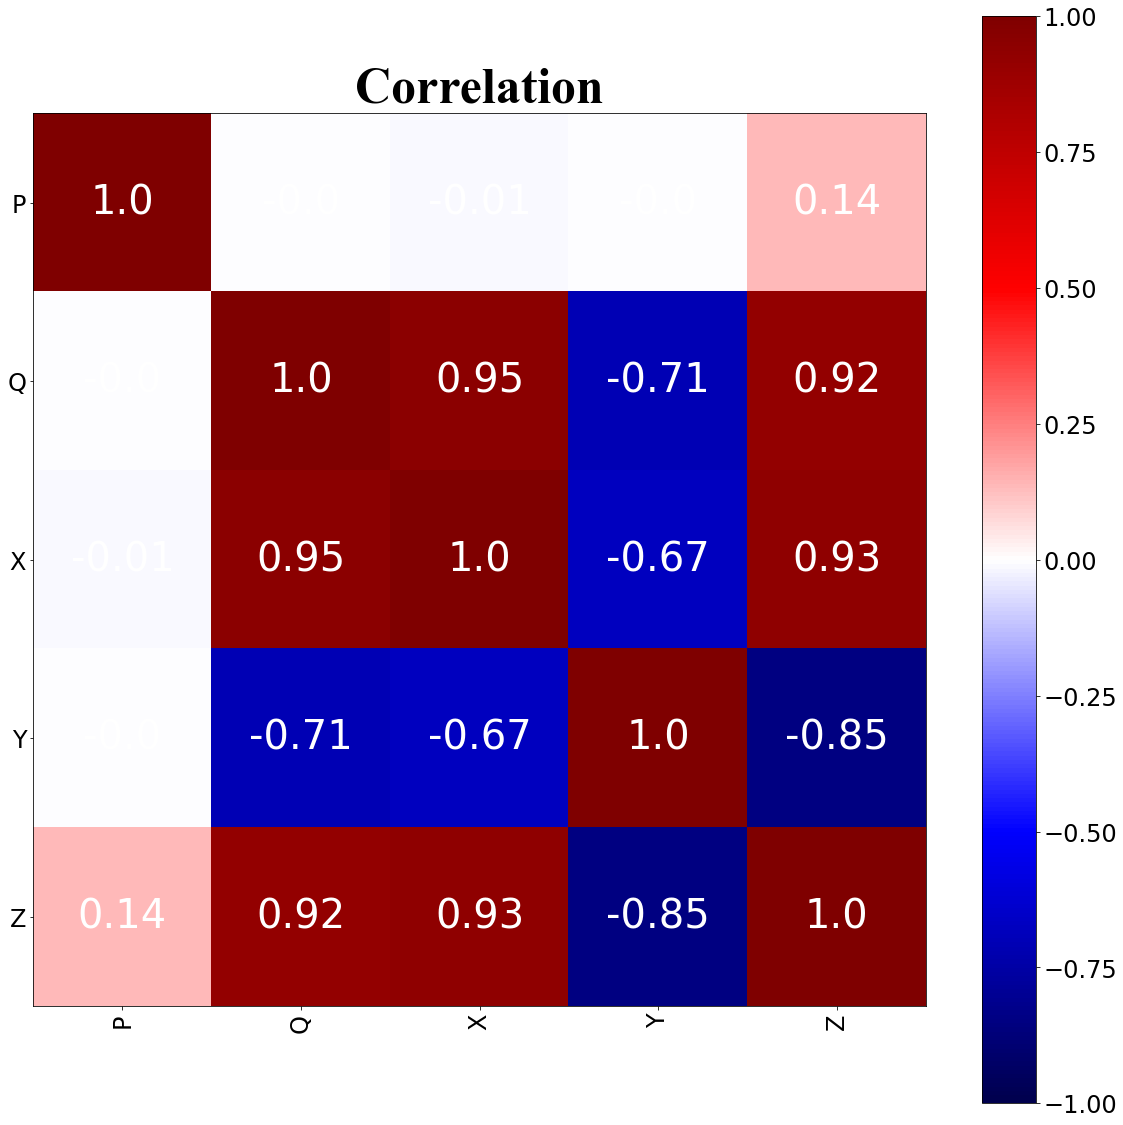

In [10]:
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None,
                    title = "Correlation")

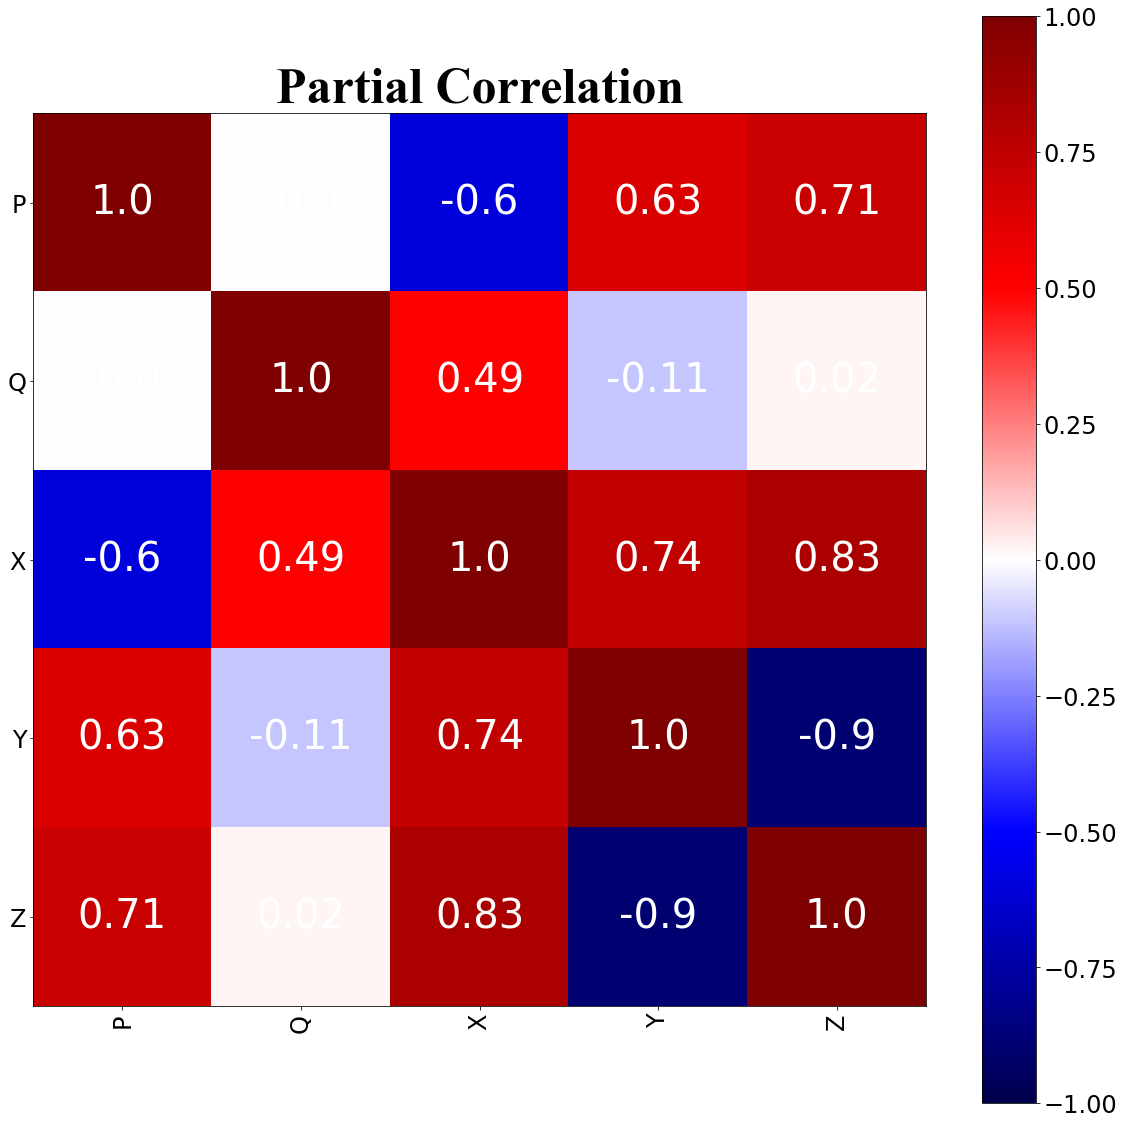

In [11]:
corr_matrix_heatmap(df.pcorr(), 
                    save_fig = False, 
                    pp = None,
                    title = "Partial Correlation")

In [12]:
pcorr_pvalues = {}

for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x!=y:
            # regress 1 residual on the other
            # save the value for the expanatory variable
            # this is the pvalue of the partial correlation
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        else:
            pcorr_pvalues[y][x] = np.NaN
pcorr_values_df = pd.DataFrame(pcorr_pvalues).round(2)
pcorr_values_df

P     Q    X    Y     Z
P   NaN  0.63  0.0  0.0  0.00
Q  0.63   NaN  0.0  0.0  0.04
X  0.00  0.00  NaN  0.0  0.00
Y  0.00  0.00  0.0  NaN  0.00
Z  0.00  0.04  0.0  0.0   NaN

In [13]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    undirected_graph[x]= [y for y in df.keys() if y != x]
undirected_graph

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [14]:
p_val = 0.01
def build_skeleton(df, undirected_graph):
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                # recursive function that iterates through remaining variables
                # uses them as controls statistical significance hold without them, 
                # otherwise break
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x!=y: 
                test = df.partial_corr(x=x, 
                                       y=y, 
                                       covar = None, 
                                       method = "pearson")
                if test["p-val"].values[0]>p_val:
                    undirected_graph[x].remove(y)
                else:
                    control_vars = [z for z in df.keys() if z!=y and z!=x]
                    check_remaining_controls(control_vars, 
                                             undirected_graph, 
                                             x, 
                                             y, 
                                             [])
    return undirected_graph

build_skeleton(df, undirected_graph)         

{'P': ['Z'],
 'Q': ['X', 'Y'],
 'X': ['Q', 'Z'],
 'Y': ['Q', 'Z'],
 'Z': ['P', 'X', 'Y']}

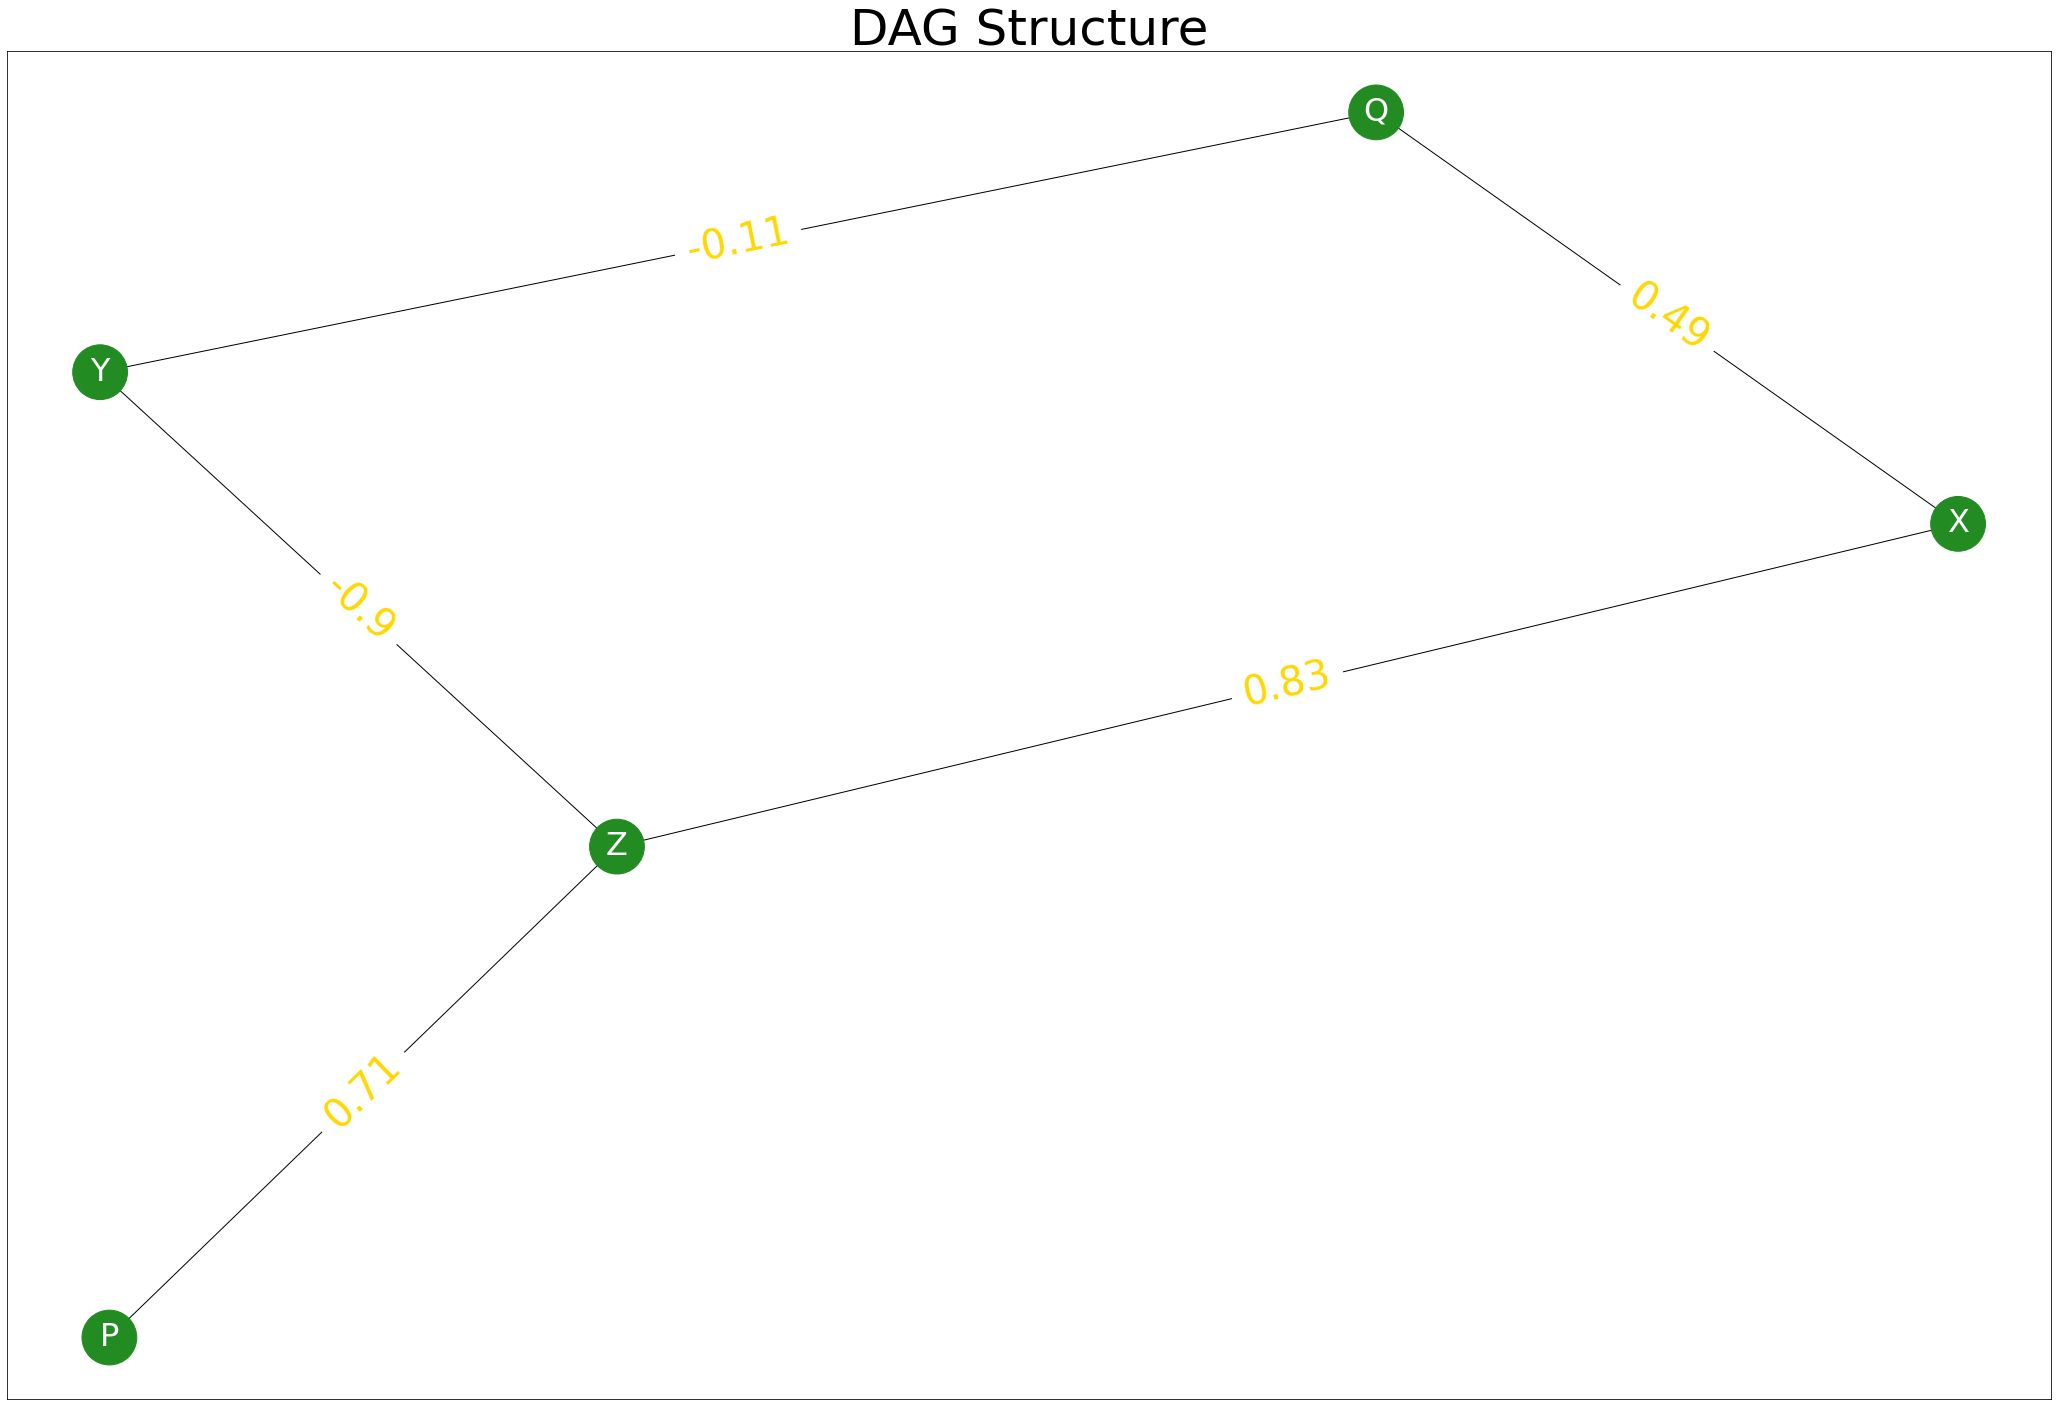

In [15]:
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key, key2)
                edges.append(edge)
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))

    graph.add_edges_from(edges)
    color_map = ["forestgreen" for g in graph]

    fig, ax = plt.subplots(figsize = (30,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)

    plt.title(title, fontsize = 50)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color=color_map, 
                     node_size = 3000,
                     with_labels=True,  
                     arrows=False,
                     font_size = 32, 
                     alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,
                                 pos,
                                 edge_labels=edge_labels,
                                 font_color='gold',
                                 font_size=40)
    
    plt.show()
graph_DAG(undirected_graph, df)

In [16]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2

model = c.estimate(return_type = "dag", 
                   variant = "parallel", # "orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

Keep Control: Y
Keep Control: X
('P', 'Z') ['Y', 'X']
Keep Control: Y
Keep Control: P
('X', 'Z') ['Y', 'P']
Keep Control: X
Keep Control: P
('Y', 'Z') ['X', 'P']
('Q', 'Y') []
('Q', 'X') []


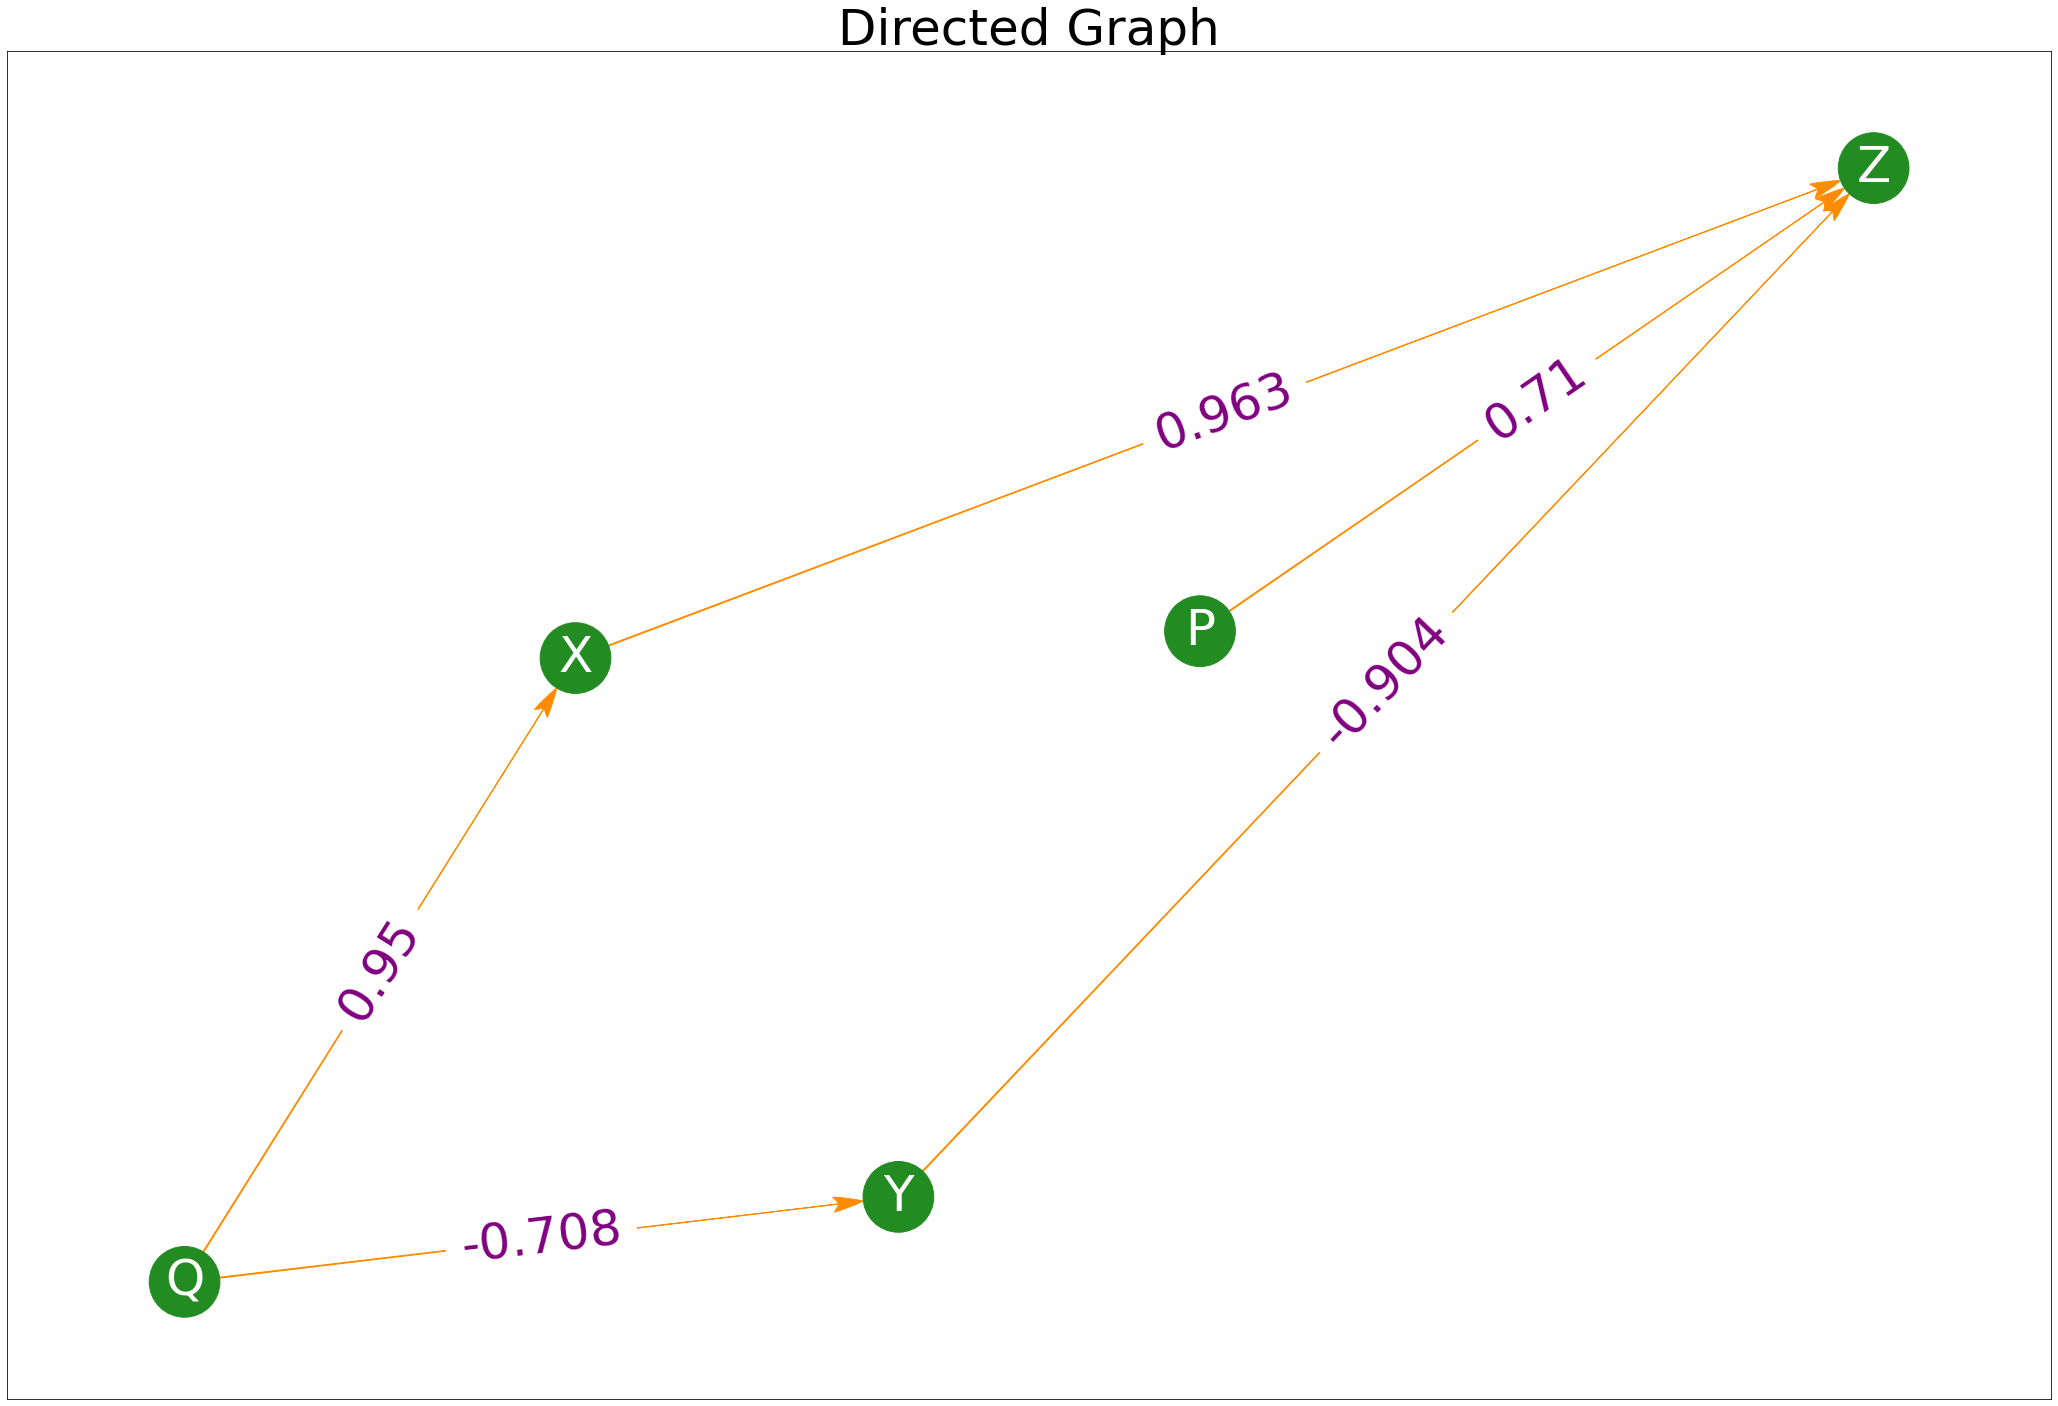

In [18]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges,
              df, 
              title = "Directed Graph"):
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        control = [key for key in df.keys() if key not in edge]
        control = list(set(control))
        keep_control = []
        for control in control:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0]]
            if (control, edge[1]) in control_edges:
                print("Keep Control:",  control)
                keep_control.append(control)
        print(edge, keep_control)
        # build a pcorr matrix with nodes from the edge + controls
        pcorr = df[[edge[0], edge[1]]+keep_control].pcorr()
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],3))
        
    graph.add_edges_from(edges)
    color_map = ["forestgreen" for g in graph]
    
    fig, ax = plt.subplots(figsize = (30,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
    plt.title(title, 
              fontsize = 50)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color = color_map, 
                     node_size = 5000, 
                     font_color = "white", 
                     font_size = 50, 
                     alpha = 1, 
                     width = 1, 
                     edge_color = "darkorange", 
                     arrowstyle = ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), 
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,
                                 pos, 
                                 edge_labels = edge_labels, 
                                 font_color = "purple", 
                                 font_size = 50)
    plt.show()
graph_DAG(edges, df)